# Plot Meteo Parameters

In [1]:
import numpy as np
import pandas as pd
import obspy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
from datetime import datetime, timedelta
import time
from scipy import signal
from ComputeAttributes_CH_V1 import *
from DF_detections import *
from ILL_functions import *

In [2]:
# set plotting default parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (6.4, 4.8) # if wider plot, only change first value.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']

In [16]:
# read df
year = 2020
file_ending = 'test_v4_bigsf_clf2'
file_ending_ILLx8 = 'v4_bigsf_clf2_ILLx8_new'

# df detections, list with window times, list with window detections, list with SF-window times, list with SF detections (only ones)
class_res, dttimes, all_class, tslops, dslops = read_features(year, file_ending)
# df detections, list with window times, list with window detections, list with SF-window times, list with SF detections (only ones)
class_res_ILLx8, dttimes_ILLx8, all_class_ILLx8, tslops_ILLx8, dslops_ILLx8 = read_features(year, file_ending_ILLx8)

# df sum by day, df sum by hour, df meteo hourly, df meteo sum by day, as ns_dat with columd datetime as index
df_group_d, df_group, ns_dat, ns_group_d, ns_group = read_meteo(class_res, year)

ts,te = DF_detections(year) # start and endtimes of DFs

In [17]:
# df detections without DFs, df meteo from beginning to end of seismic season, df meteo witout DFs
class_mask, ns_dat_per, ns_dat_mask = mask_debrisflow(class_res, ns_dat, ts, te)
# df moisture from beginning to end of sesimic season, df moisture without DFs
df_mois_per,df_mois_mask = mask_moisture(class_res, ts, te)
# df including all parameters, as group_all_DF without DFs, as group_all_DF but resampled over 6h, as group_all5_DF but without DF
group_all_DF, group_all, group_all5_DF, group_all5 = some_processing_with_moisture(class_res, class_mask, ns_dat_per, ns_dat_mask, df_mois_per, df_mois_mask)

/media/manuela/UNTITLED/illgraben/code/ILL_functions.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ns_dat_mask.loc[ns_dat_per[ns_mask].index, '267'] = 0
/media/manuela/UNTITLED/illgraben/code/ILL_functions.py:125: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mois_mask.loc[df_mois_per[mois_mask].index, df_mois.columns.values[1:8]] = 0 # df without DFs


In [5]:
print(group_all_DF['classes'].sum())
print(group_all['classes'].sum())

6859
3963


In [22]:
idx_date = [idx.date() for idx in group_all_DF.index]
ts_date = [datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S").date() for ts_i in ts]
starts = list(set(ts_date).intersection(idx_date)) # only dates include in both lists
ends = [start + timedelta(days=1) for start in starts]

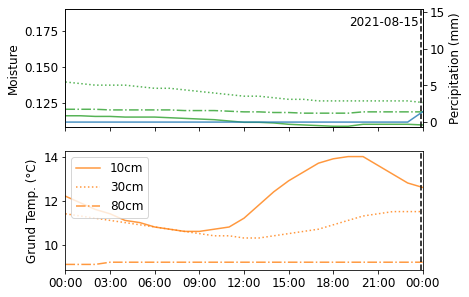

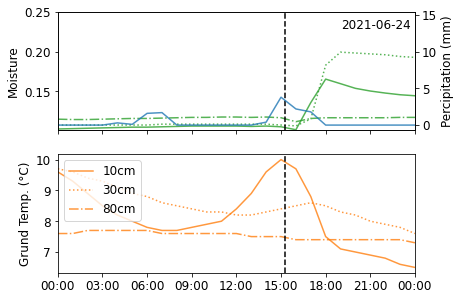

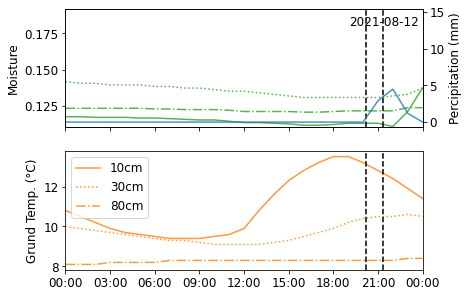

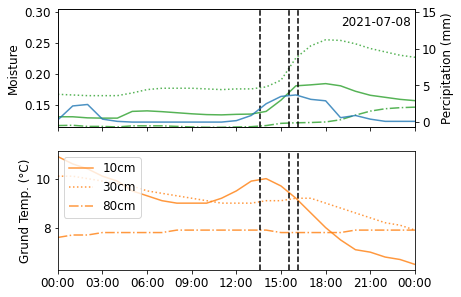

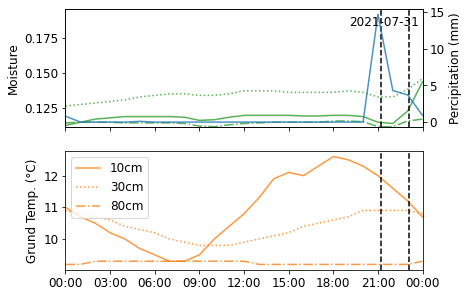

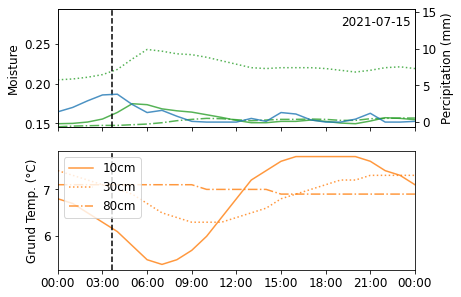

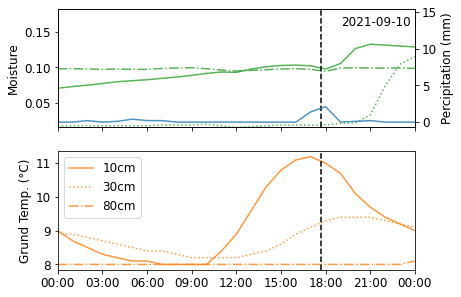

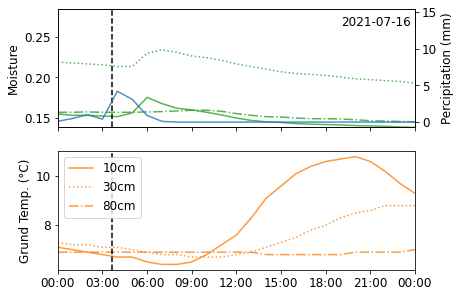

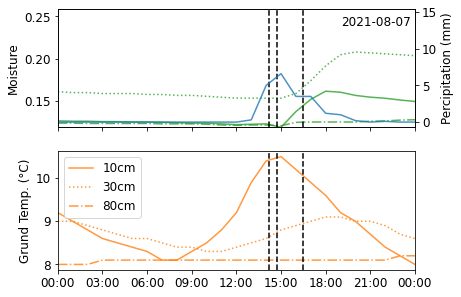

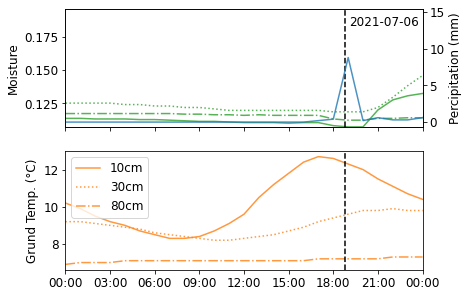

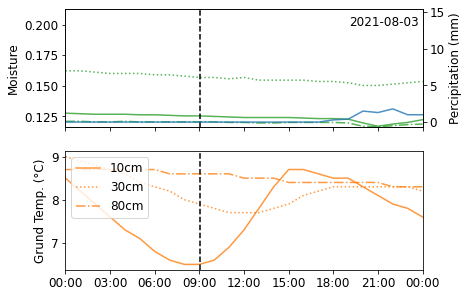

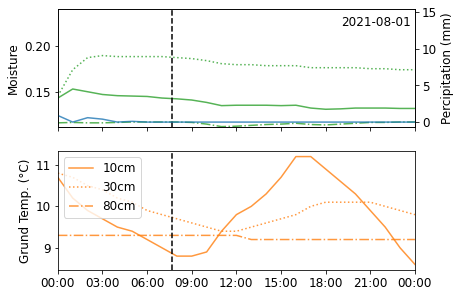

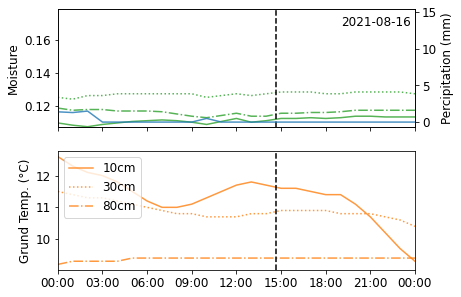

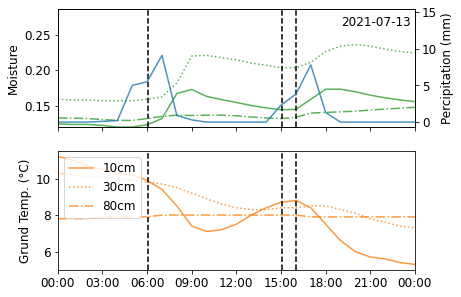

In [23]:
save_dir = f'../plot/{year}/moisture_daily'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for start, end in zip(starts,ends):
    start = obspy.UTCDateTime(start).datetime
    end = obspy.UTCDateTime(end).datetime
    group_all_DF_mask = group_all_DF.copy()
    mask_all = (group_all_DF['datetime'] >= start) & (group_all_DF['datetime'] <= end)
    group_all_DF_mask = group_all_DF_mask.loc[group_all_DF[mask_all].index] # df one day long
    
    fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4, 4.8), sharex=True)
    ax2 = ax1.twinx()
    ax2.plot(group_all_DF['267'], linestyle='-', color='C0', alpha=0.8)
    ax2.set_ylabel('Percipitation (mm)')
    ax1.plot(group_all_DF_mask['SM10cm'], linestyle='-', color='C2', alpha=0.8, label='10cm')
    ax1.plot(group_all_DF_mask['SM30cm'], linestyle=':', color='C2', alpha=0.8, label='30cm')
    ax1.plot(group_all_DF_mask['SM80cm'], linestyle='-.', color='C2', alpha=0.8, label='80cm')
    ax1.set_ylabel('Moisture')
    y_min_a = min(min(group_all_DF_mask['SM10cm']), min(group_all_DF_mask['SM30cm']), min(group_all_DF_mask['SM80cm']))
    y_min = math.floor(y_min_a * 1000) / 1000.0 # round down to 3thrd digit
    y_max_a = max(max(group_all_DF_mask['SM10cm']), max(group_all_DF_mask['SM30cm']), max(group_all_DF_mask['SM80cm']))
    y_max = math.ceil(y_max_a * 1000) / 1000.0 # round up to 3thrd digit
    ax1.set_ylim(y_min,y_max+0.05)

    
    ax0.plot(group_all_DF_mask['T10cm'], linestyle='-', color='C1', alpha=0.8, label='10cm')
    ax0.plot(group_all_DF_mask['T30cm'], linestyle=':', color='C1', alpha=0.8, label='30cm')
    ax0.plot(group_all_DF_mask['T80cm'], linestyle='-.', color='C1', alpha=0.8, label='80cm')
    ax0.set_ylabel('Grund Temp. (°C)')
    
    # Plot debris-flow events as vertical lines
    for ts_i in ts:
        ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), linestyle='--', color='k')
        ax0.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), linestyle='--', color='k')
    ax0.set_xlim(start,end)
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    ax0.legend(loc='upper left')
    fig.text(0.74,0.83, f'{start.date()}')
    plt.savefig(save_dir + f'/{start.date()}.png',bbox_inches='tight', dpi=300)

# Moisture & Ground Temperature Season plot

In [18]:
df_mois = pd.read_csv(f'../meteodata/Illhorn1_2019-2021.csv') # load moisture and temperature (ground)
df_mois['datetime'] = pd.to_datetime(df_mois['Illhorn1'])
df_mois = df_mois.set_index('datetime', drop=False)
df_mois.head()

Illhorn1    SM10cm   SM30cm    SM50cm  \
datetime                                                                    
2019-10-16 13:00:00  2019-10-16 13:00:00.000  0.046208  0.00865 -0.073909   
2019-10-16 14:00:00  2019-10-16 14:00:00.000  0.118347  0.16234  0.024815   
2019-10-16 15:00:00  2019-10-16 15:00:00.000  0.117448  0.16343  0.027667   
2019-10-16 16:00:00  2019-10-16 16:00:00.000  0.116097  0.16234  0.030495   
2019-10-16 17:00:00  2019-10-16 17:00:00.000  0.115195  0.16234  0.031433   

                       SM80cm  T10cm  T30cm  T80cm            datetime  
datetime                                                                
2019-10-16 13:00:00  0.043666    1.5    2.1    2.9 2019-10-16 13:00:00  
2019-10-16 14:00:00  0.076898    1.3    2.7    3.0 2019-10-16 14:00:00  
2019-10-16 15:00:00  0.076898    1.2    2.6    3.5 2019-10-16 15:00:00  
2019-10-16 16:00:00  0.077380    1.2    2.5    3.7 2019-10-16 16:00:00  
2019-10-16 17:00:00  0.077380    1.2    2.4    3.8 2019-10-16 17:00:00

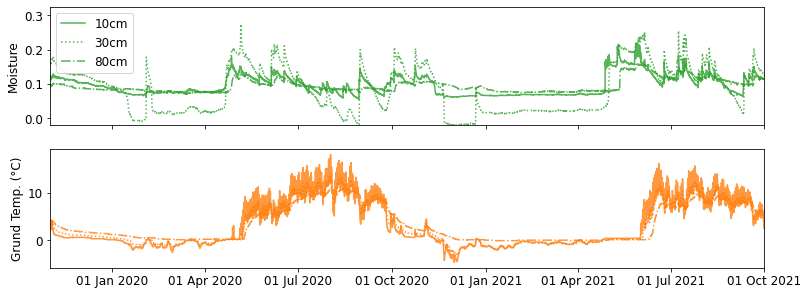

In [132]:
season ='spring'
start = obspy.UTCDateTime('2019-11-01').datetime
end = obspy.UTCDateTime('2021-10-01').datetime

fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4*2, 4.8), sharex=True)
ax1.plot(df_mois['SM10cm'], linestyle='-', color='C2', alpha=0.8, label='10cm')
ax1.plot(df_mois['SM30cm'], linestyle=':', color='C2', alpha=0.8, label='30cm')
ax1.plot(df_mois['SM80cm'], linestyle='-.', color='C2', alpha=0.8, label='80cm')
ax1.set_ylabel('Moisture')
y_min_a = min(min(df_mois['SM10cm']), min(df_mois['SM30cm']), min(df_mois['SM80cm']))
y_min = math.floor(y_min_a * 1000) / 1000.0 # round down to 3thrd digit
y_max_a = max(max(df_mois['SM10cm']), max(df_mois['SM30cm']), max(df_mois['SM80cm']))
y_max = math.ceil(y_max_a * 1000) / 1000.0 # round up to 3thrd digit
ax1.set_ylim(y_min,y_max+0.05)

ax0.plot(df_mois['T10cm'], linestyle='-', color='C1', alpha=0.8, label='Ground Temp. 10cm')
ax0.plot(df_mois['T30cm'], linestyle=':', color='C1', alpha=0.8, label='Ground Temp. 30cm')
ax0.plot(df_mois['T80cm'], linestyle='-.', color='C1', alpha=0.8, label='Ground Temp. 80cm')
ax0.set_ylabel('Grund Temp. (°C)')

ax0.set_xlim(start,end)
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

ax1.legend(loc='upper left')
#fig.text(0.82,0.83, f'{start.year}')
#plt.savefig(save_dir + f'/{start.year}_{season}_{plot_ending}.png',bbox_inches='tight', dpi=300)
plt.savefig( f'../plot/moisture_overview.png',bbox_inches='tight', dpi=300)

# Strong rainfall events

I define a strong rainfall event a day, during which eighter the summed precipitation per day exceeds 5mm/d OR 1mm/h OR 0.0125/h.

In [19]:
# get dates of strong rainfall days (>5mm/d)
ns_strong_d = ns_group_d[ns_group_d['267']>5]
ns_strong_d.index

Index([2020-01-28, 2020-01-29, 2020-02-02, 2020-02-04, 2020-02-13, 2020-02-26,
       2020-02-27, 2020-02-29, 2020-03-01, 2020-03-02, 2020-03-05, 2020-03-10,
       2020-04-28, 2020-05-01, 2020-05-02, 2020-05-05, 2020-05-10, 2020-05-23,
       2020-06-04, 2020-06-06, 2020-06-07, 2020-06-09, 2020-06-10, 2020-06-16,
       2020-06-17, 2020-06-29, 2020-07-11, 2020-07-22, 2020-07-24, 2020-08-10,
       2020-08-16, 2020-08-28, 2020-08-29, 2020-08-30, 2020-09-24, 2020-09-25,
       2020-09-26, 2020-10-02, 2020-10-03, 2020-10-06, 2020-10-23, 2020-10-26,
       2020-11-16, 2020-12-04, 2020-12-05, 2020-12-06, 2020-12-12, 2020-12-21,
       2020-12-24],
      dtype='object', name='datetime')

In [20]:
# get dates of strong rainfall days (>1mm/h)
ns_strong_h = ns_group[ns_group['267']>1]
ns_strong_h['date'] = ns_strong_h.index.date # get date of measurement
ns_strong_h

<ipython-input-20-c9223c6a934b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ns_strong_h['date'] = ns_strong_h.index.date # get date of measurement


266  261  267  274  269  283    306  580        date
datetime                                                                  
2020-01-27 22:00:00  94.0 -0.5  1.1    0    2  2.2  851.4  0.0  2020-01-27
2020-01-28 03:00:00  95.5 -0.9  1.1    0    2  1.7  848.6  0.0  2020-01-28
2020-01-28 04:00:00  96.3 -0.9  1.3    0    2  1.3  848.2  0.0  2020-01-28
2020-01-28 11:00:00  92.6 -0.5  1.7    0   22  4.5  847.0  0.0  2020-01-28
2020-01-28 14:00:00  96.6 -2.0  3.4    0   30  4.0  847.5  0.0  2020-01-28
...                   ...  ...  ...  ...  ...  ...    ...  ...         ...
2020-12-21 21:00:00  97.4  1.2  1.9    0    1  0.9  863.6  0.0  2020-12-21
2020-12-21 22:00:00  97.6  1.3  1.3    0    1  1.0  864.0  0.0  2020-12-21
2020-12-24 02:00:00  92.4  3.8  1.5    0    1  1.5  855.4  0.0  2020-12-24
2020-12-24 03:00:00  95.6  3.8  1.3    0    1  1.4  855.0  0.0  2020-12-24
2020-12-28 23:00:00  92.8 -4.7  1.2    0    1  1.0  828.8  0.0  2020-12-28

[257 rows x 9 columns]

In [21]:
df_mois['date'] = df_mois.index.date
df_mois['SM10cm`'] = df_mois['SM10cm'].diff()
df_mois['SM30cm`'] = df_mois['SM30cm'].diff()
df_mois['SM80cm`'] = df_mois['SM80cm'].diff()
df_mois.head()

Illhorn1    SM10cm   SM30cm    SM50cm  \
datetime                                                                    
2019-10-16 13:00:00  2019-10-16 13:00:00.000  0.046208  0.00865 -0.073909   
2019-10-16 14:00:00  2019-10-16 14:00:00.000  0.118347  0.16234  0.024815   
2019-10-16 15:00:00  2019-10-16 15:00:00.000  0.117448  0.16343  0.027667   
2019-10-16 16:00:00  2019-10-16 16:00:00.000  0.116097  0.16234  0.030495   
2019-10-16 17:00:00  2019-10-16 17:00:00.000  0.115195  0.16234  0.031433   

                       SM80cm  T10cm  T30cm  T80cm            datetime  \
datetime                                                                 
2019-10-16 13:00:00  0.043666    1.5    2.1    2.9 2019-10-16 13:00:00   
2019-10-16 14:00:00  0.076898    1.3    2.7    3.0 2019-10-16 14:00:00   
2019-10-16 15:00:00  0.076898    1.2    2.6    3.5 2019-10-16 15:00:00   
2019-10-16 16:00:00  0.077380    1.2    2.5    3.7 2019-10-16 16:00:00   
2019-10-16 17:00:00  0.077380    1.2    2.4    3.8 2019-10-16 17:00:00   

                           date   SM10cm`  SM30cm`   SM80cm`  
datetime                                                      
2019-10-16 13:00:00  2019-10-16       NaN      NaN       NaN  
2019-10-16 14:00:00  2019-10-16  0.072139  0.15369  0.033231  
2019-10-16 15:00:00  2019-10-16 -0.000899  0.00109  0.000000  
2019-10-16 16:00:00  2019-10-16 -0.001351 -0.00109  0.000483  
2019-10-16 17:00:00  2019-10-16 -0.000902  0.00000  0.000000

In [22]:
# choose rows where at least one of the moisture measuremetns achieve 0.0125 and drop first line (only nan)
df_mois_strong = df_mois[(df_mois[['SM10cm`','SM30cm`','SM80cm`']]>0.0125).any(axis=1)].dropna()
df_mois_strong

Illhorn1    SM10cm   SM30cm    SM50cm  \
datetime                                                                        
2019-10-16 14:00:00.000  2019-10-16 14:00:00.000  0.118347  0.16234  0.024815   
2020-02-03 02:00:00.000  2020-02-03 02:00:00.000  0.069612  0.08822 -0.011324   
2020-02-03 03:00:00.000  2020-02-03 03:00:00.000  0.070101  0.16234 -0.007129   
2020-02-03 04:00:00.000  2020-02-03 04:00:00.000  0.070589  0.17869 -0.000922   
2020-05-05 18:00:00.000  2020-05-05 18:00:00.000  0.150142  0.26698  0.144693   
...                                          ...       ...      ...       ...   
2021-09-10 20:00:40.380  2021-09-10 20:00:40.380  0.126809  0.02173  0.008197   
2021-09-10 22:00:40.390  2021-09-10 22:00:40.390  0.131648  0.07405  0.008197   
2021-09-10 23:00:40.395  2021-09-10 23:00:40.395  0.130333  0.10457  0.008197   
2021-09-19 09:00:41.405  2021-09-19 09:00:41.405  0.133833  0.12964  0.027667   
2021-09-19 10:00:41.410  2021-09-19 10:00:41.410  0.137310  0.14599  0.027667   

                           SM80cm  T10cm  T30cm  T80cm  \
datetime                                                 
2019-10-16 14:00:00.000  0.076898    1.3    2.7    3.0   
2020-02-03 02:00:00.000  0.075931   -0.1    0.1    0.4   
2020-02-03 03:00:00.000  0.075931   -0.1    0.1    0.4   
2020-02-03 04:00:00.000  0.075448    0.0    0.1    0.4   
2020-05-05 18:00:00.000  0.132523    3.2    0.2    0.2   
...                           ...    ...    ...    ...   
2021-09-10 20:00:40.380  0.099626   10.1    9.4    8.0   
2021-09-10 22:00:40.390  0.099162    9.4    9.3    8.0   
2021-09-10 23:00:40.395  0.099162    9.2    9.2    8.0   
2021-09-19 09:00:41.405  0.102405    6.1    7.1    7.6   
2021-09-19 10:00:41.410  0.101943    5.5    7.0    7.6   

                                       datetime        date   SM10cm`  \
datetime                                                                
2019-10-16 14:00:00.000 2019-10-16 14:00:00.000  2019-10-16  0.072139   
2020-02-03 02:00:00.000 2020-02-03 02:00:00.000  2020-02-03  0.000978   
2020-02-03 03:00:00.000 2020-02-03 03:00:00.000  2020-02-03  0.000488   
2020-02-03 04:00:00.000 2020-02-03 04:00:00.000  2020-02-03  0.000488   
2020-05-05 18:00:00.000 2020-05-05 18:00:00.000  2020-05-05  0.000000   
...                                         ...         ...       ...   
2021-09-10 20:00:40.380 2021-09-10 20:00:40.380  2021-09-10  0.021179   
2021-09-10 22:00:40.390 2021-09-10 22:00:40.390  2021-09-10 -0.001312   
2021-09-10 23:00:40.395 2021-09-10 23:00:40.395  2021-09-10 -0.001315   
2021-09-19 09:00:41.405 2021-09-19 09:00:41.405  2021-09-19  0.015486   
2021-09-19 10:00:41.410 2021-09-19 10:00:41.410  2021-09-19  0.003477   

                         SM30cm`   SM80cm`  
datetime                                    
2019-10-16 14:00:00.000  0.15369  0.033231  
2020-02-03 02:00:00.000  0.07194  0.000000  
2020-02-03 03:00:00.000  0.07412  0.000000  
2020-02-03 04:00:00.000  0.01635 -0.000484  
2020-05-05 18:00:00.000  0.01635  0.000875  
...                          ...       ...  
2021-09-10 20:00:40.380  0.00109  0.000465  
2021-09-10 22:00:40.390  0.04142  0.000000  
2021-09-10 23:00:40.395  0.03052  0.000000  
2021-09-19 09:00:41.405  0.00654  0.000000  
2021-09-19 10:00:41.410  0.01635 -0.000462  

[67 rows x 13 columns]

In [23]:
strong_days = np.unique([*ns_strong_d.index.to_list(), *ns_strong_h['date'].to_list(), *df_mois_strong['date'].to_list()])
# array includes dates ONCE where the preciitation exceeds 5mm/d or 1mm/h or moisture exceeds 0.0125/hr

In [24]:
# create df with hourly precipitation and moisture measurements of the strong prec./mois. days
df_mois_res = df_mois.copy().resample('1H').sum() # resample because some measurements at xx:xx:43
df_mois_res['date'] = df_mois_res.index.date # had to be added after resampling
mois_strong = df_mois_res[df_mois_res['date'].isin(strong_days)] # check if heavy rain day
ns_group['date'] = ns_group.index.date # get date of measurement
ns_strong = ns_group[ns_group['date'].isin(strong_days)] # check if heavy rain day
ns_strong = ns_strong.drop('date', axis=1) # otherwise twice after next step (concat)
df_strong = pd.concat([mois_strong, ns_strong], axis=1).dropna() # add dfs to the left (rowwise)
df_strong

SM10cm   SM30cm    SM50cm    SM80cm  T10cm  T30cm  \
datetime                                                                   
2020-01-27 00:00:00  0.068634 -0.00661 -0.025281  0.083619   -1.5   -0.9   
2020-01-27 01:00:00  0.068634 -0.00661 -0.025281  0.083619   -1.5   -0.9   
2020-01-27 02:00:00  0.069123 -0.00661 -0.025281  0.083619   -1.5   -0.9   
2020-01-27 03:00:00  0.069123 -0.00661 -0.025281  0.083619   -1.5   -0.9   
2020-01-27 04:00:00  0.068634 -0.00661 -0.025281  0.083619   -1.5   -0.9   
...                       ...      ...       ...       ...    ...    ...   
2020-12-28 19:00:00  0.067164  0.01737 -0.025281  0.091678   -1.3   -1.2   
2020-12-28 20:00:00  0.067164  0.01628 -0.025281  0.091678   -1.3   -1.2   
2020-12-28 21:00:00  0.067164  0.01737 -0.025281  0.091678   -1.3   -1.2   
2020-12-28 22:00:00  0.067164  0.01737 -0.025281  0.091678   -1.3   -1.2   
2020-12-28 23:00:00  0.067164  0.01628 -0.025281  0.091678   -1.3   -1.2   

                     T80cm   SM10cm`  SM30cm`   SM80cm`        date   266  \
datetime                                                                    
2020-01-27 00:00:00    0.5  0.000000  0.00109  0.000000  2020-01-27  77.8   
2020-01-27 01:00:00    0.5  0.000000  0.00000  0.000000  2020-01-27  79.3   
2020-01-27 02:00:00    0.5  0.000489  0.00000  0.000000  2020-01-27  79.5   
2020-01-27 03:00:00    0.5  0.000000  0.00000  0.000000  2020-01-27  75.4   
2020-01-27 04:00:00    0.5 -0.000489  0.00000  0.000000  2020-01-27  77.3   
...                    ...       ...      ...       ...         ...   ...   
2020-12-28 19:00:00    0.1  0.000000  0.00000 -0.000471  2020-12-28  79.6   
2020-12-28 20:00:00    0.1  0.000000 -0.00109  0.000000  2020-12-28  79.0   
2020-12-28 21:00:00    0.1  0.000000  0.00109  0.000000  2020-12-28  89.9   
2020-12-28 22:00:00    0.1  0.000000  0.00000  0.000000  2020-12-28  89.9   
2020-12-28 23:00:00    0.1  0.000000 -0.00109  0.000000  2020-12-28  92.8   

                     261  267  274  269  283    306   580  
datetime                                                   
2020-01-27 00:00:00 -0.8  0.0  0.0  2.0  1.4  858.2  58.0  
2020-01-27 01:00:00 -1.5  0.0  0.0  2.0  1.6  857.9   0.0  
2020-01-27 02:00:00 -1.0  0.0  0.0  2.0  1.3  857.8   0.0  
2020-01-27 03:00:00 -1.0  0.0  0.0  2.0  1.6  857.6   0.0  
2020-01-27 04:00:00 -1.7  0.0  0.0  2.0  1.5  857.6   0.0  
...                  ...  ...  ...  ...  ...    ...   ...  
2020-12-28 19:00:00 -4.5  0.0  0.0  1.0  1.5  827.0   0.0  
2020-12-28 20:00:00 -4.0  0.0  0.0  1.0  1.6  827.5   0.0  
2020-12-28 21:00:00 -4.6  0.6  0.0  1.0  1.4  828.2   0.0  
2020-12-28 22:00:00 -4.6  0.7  0.0  1.0  1.4  828.3   0.0  
2020-12-28 23:00:00 -4.7  1.2  0.0  1.0  1.0  828.8   0.0  

[1896 rows x 19 columns]

<ipython-input-26-9f2af36e15c9>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4, 4.8), sharex=True)


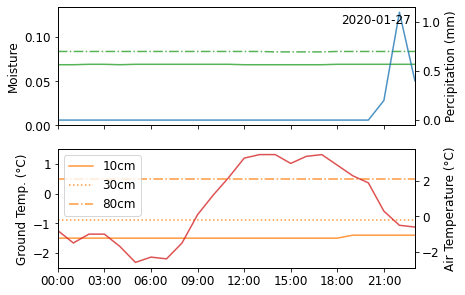

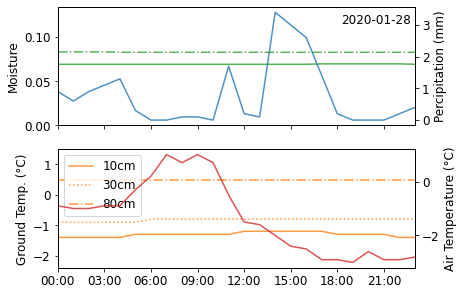

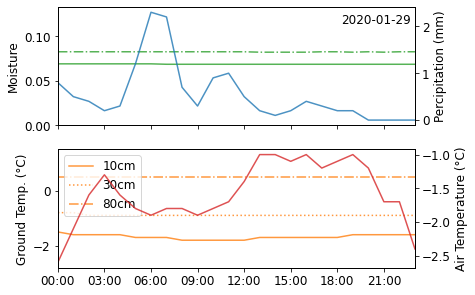

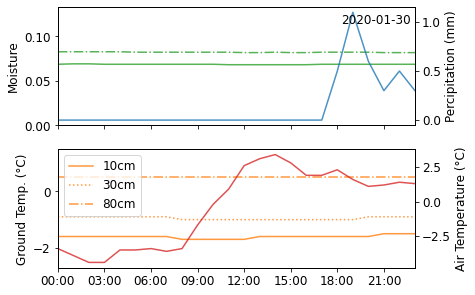

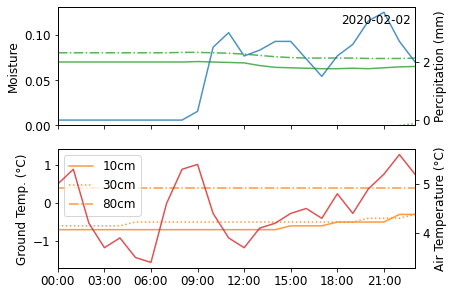

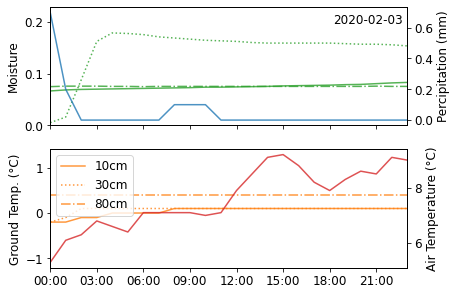

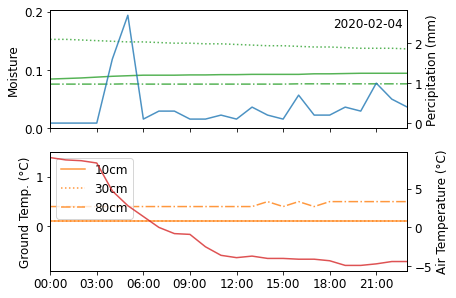

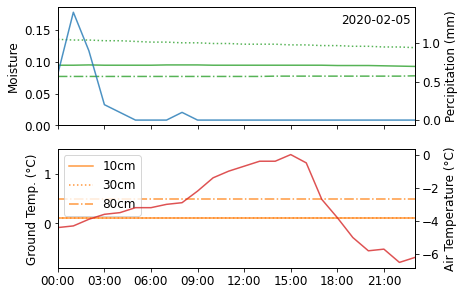

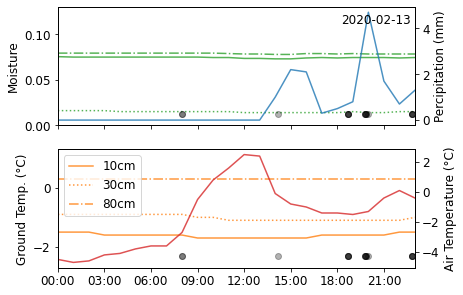

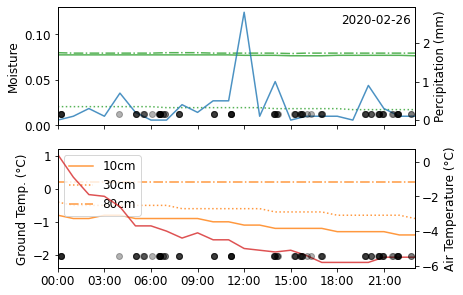

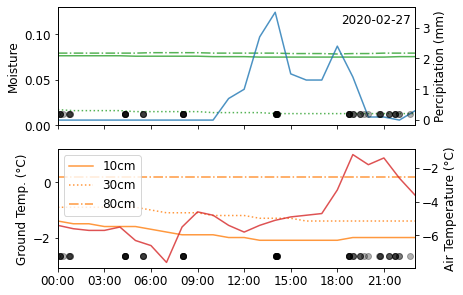

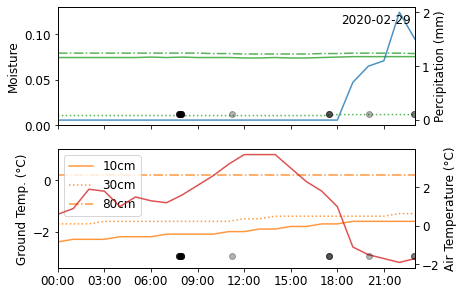

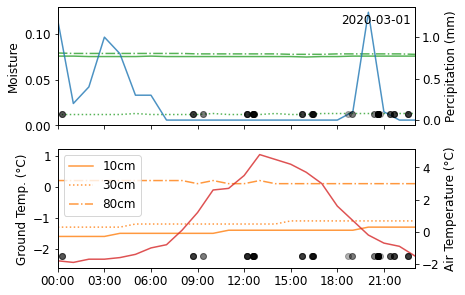

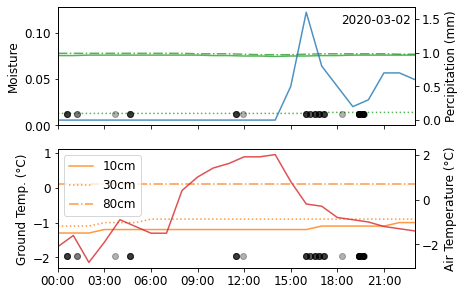

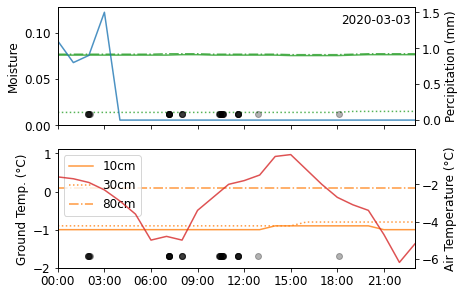

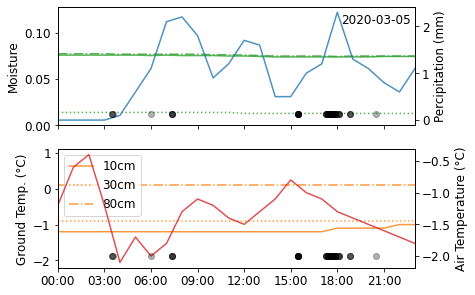

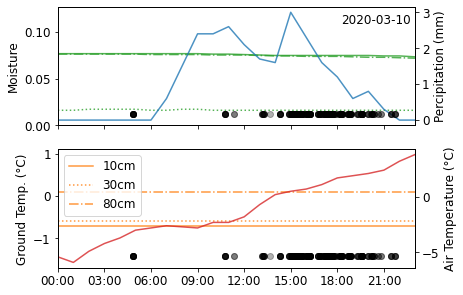

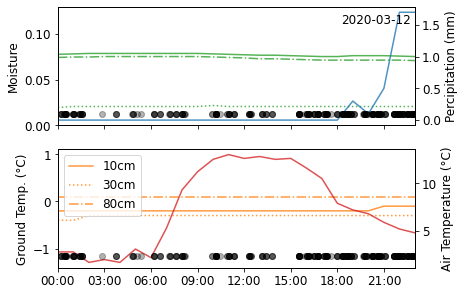

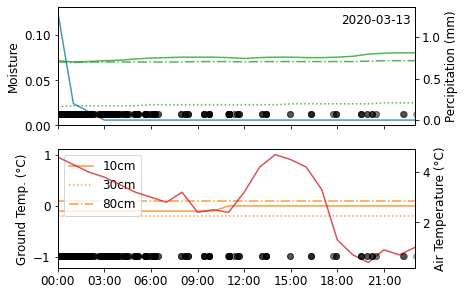

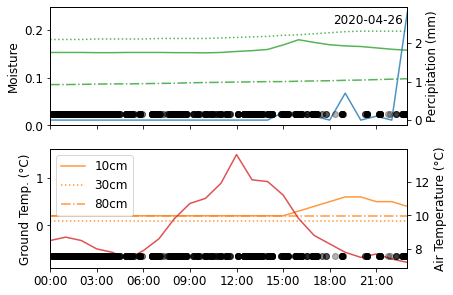

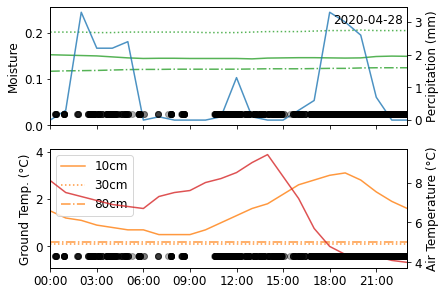

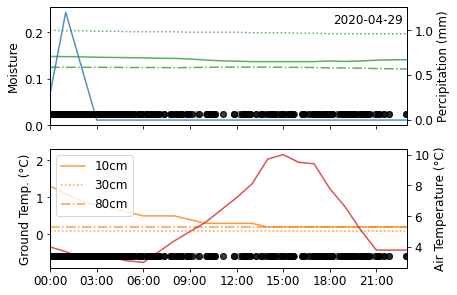

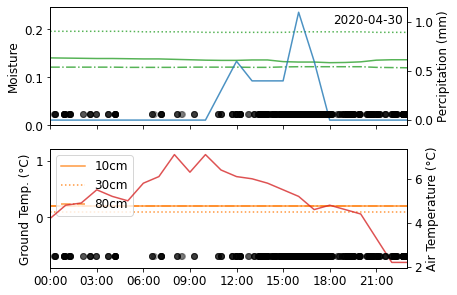

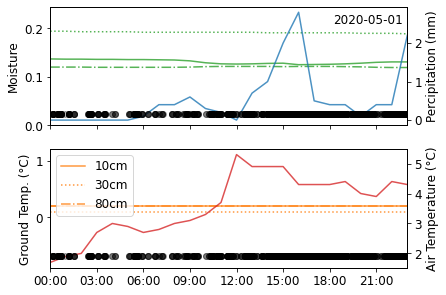

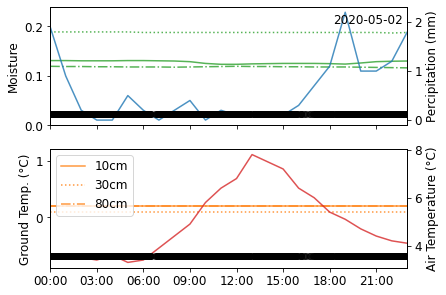

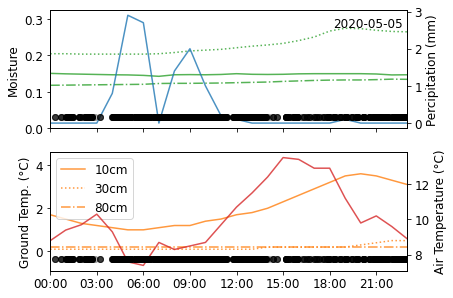

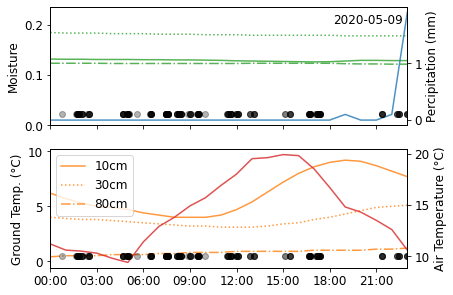

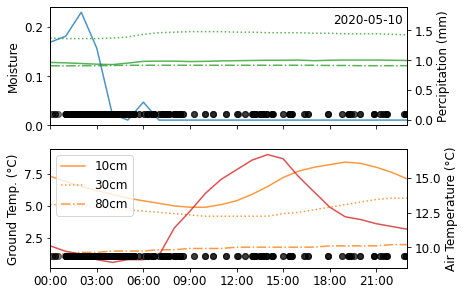

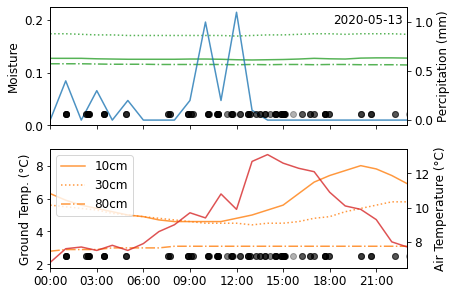

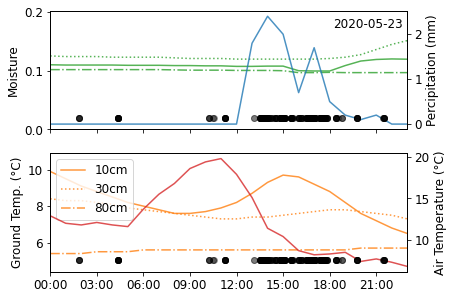

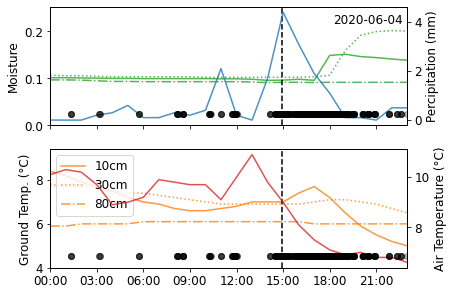

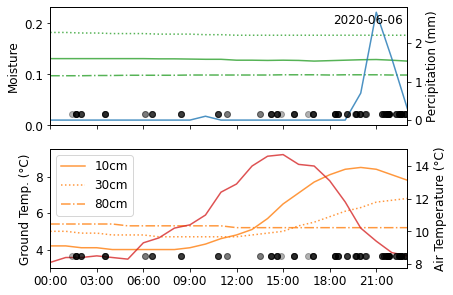

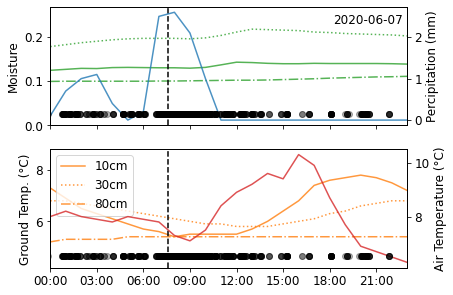

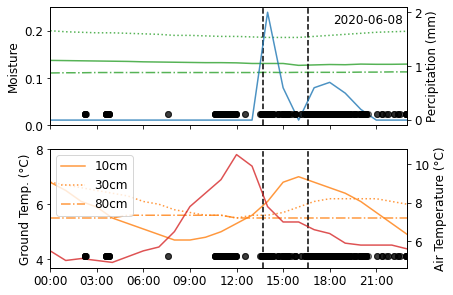

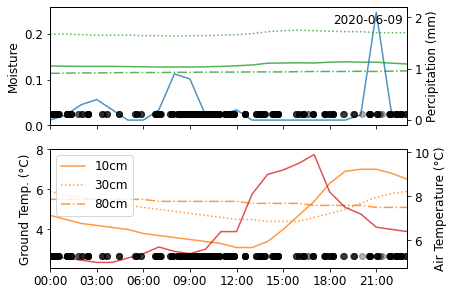

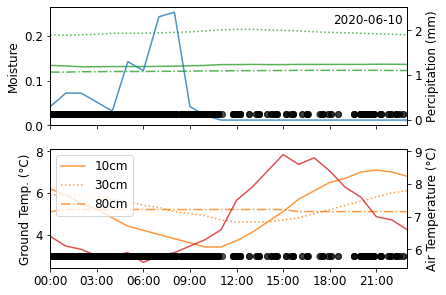

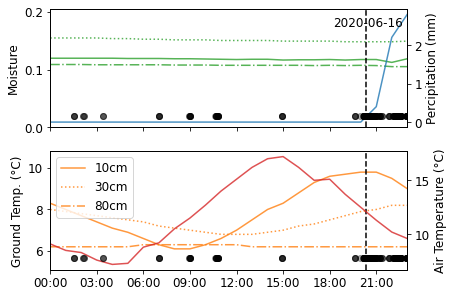

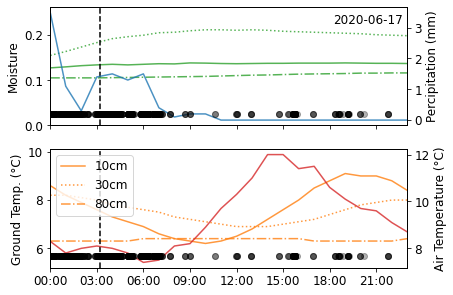

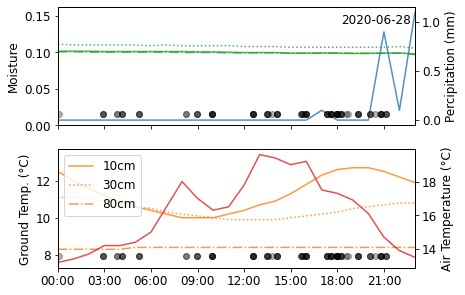

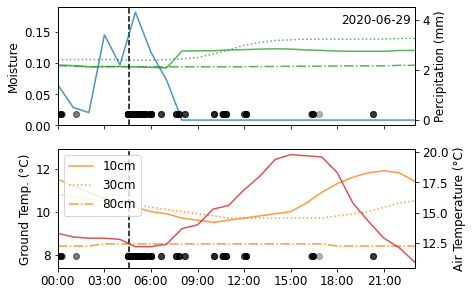

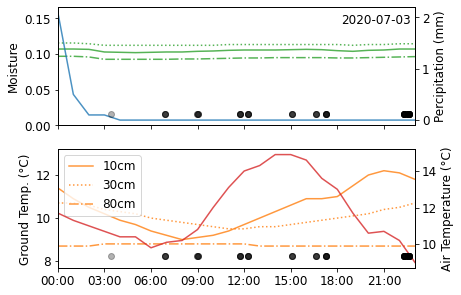

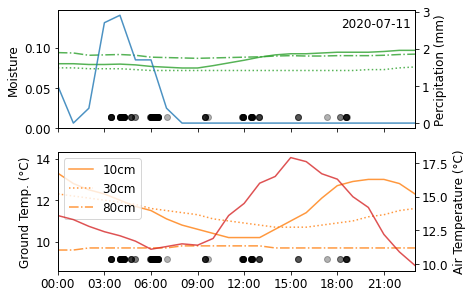

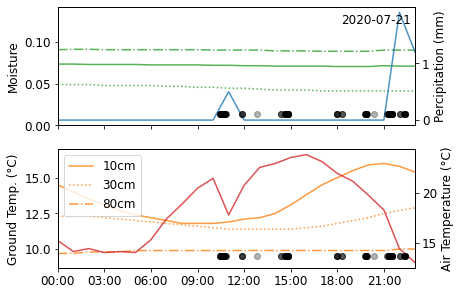

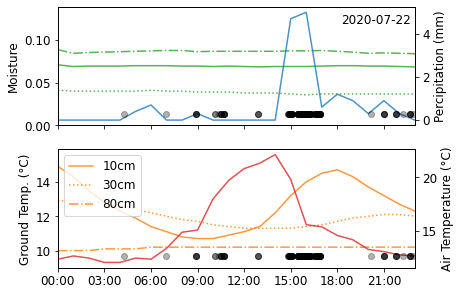

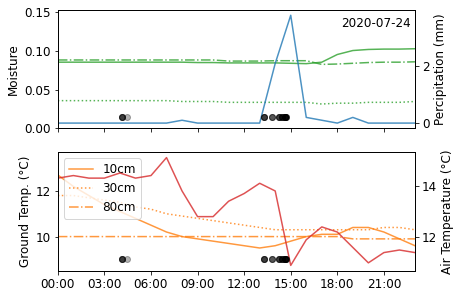

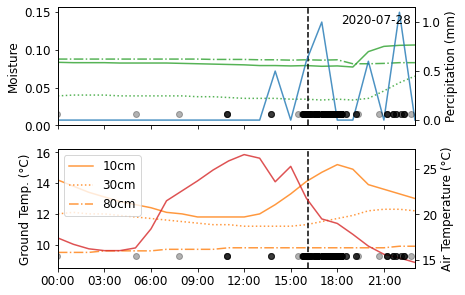

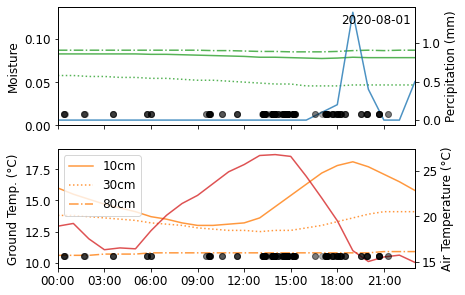

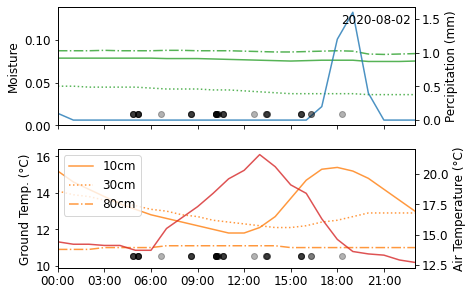

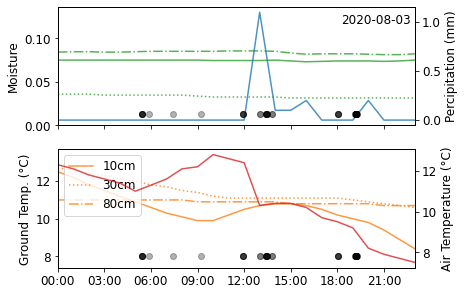

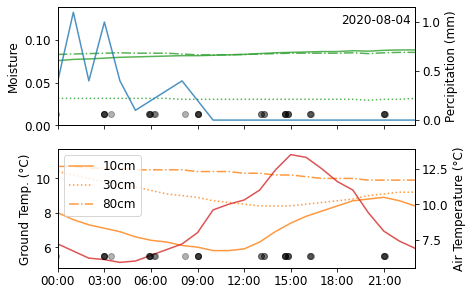

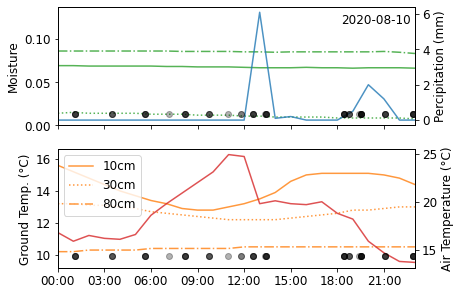

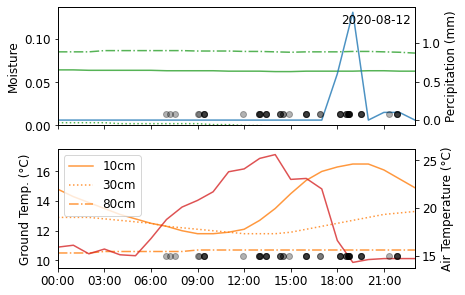

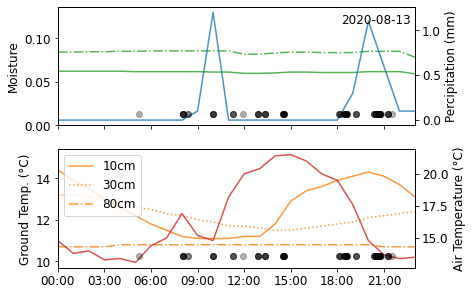

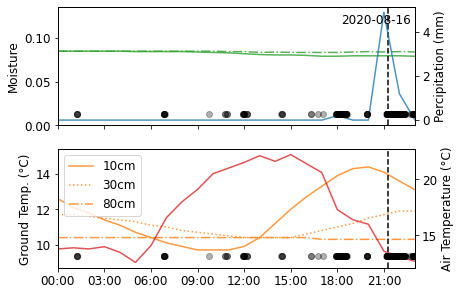

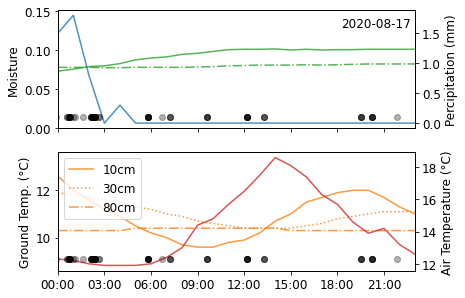

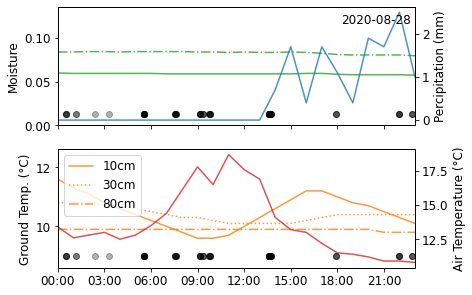

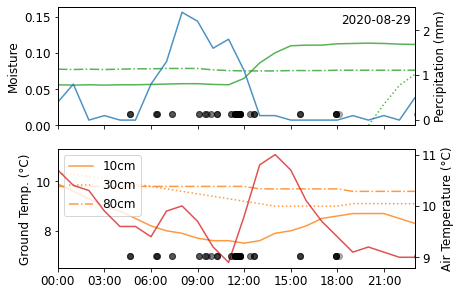

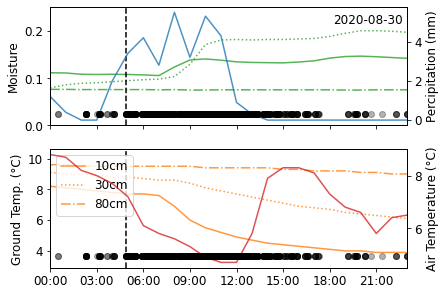

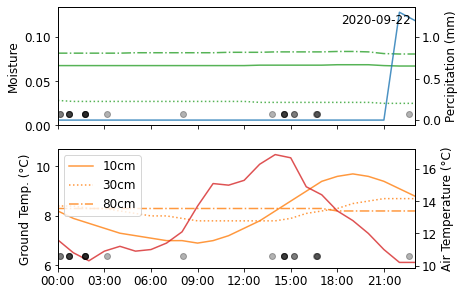

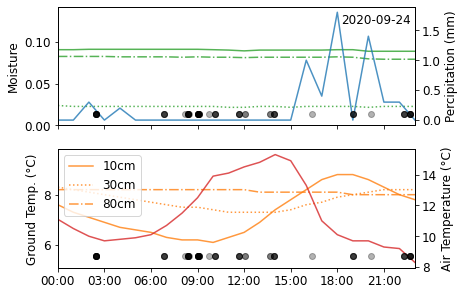

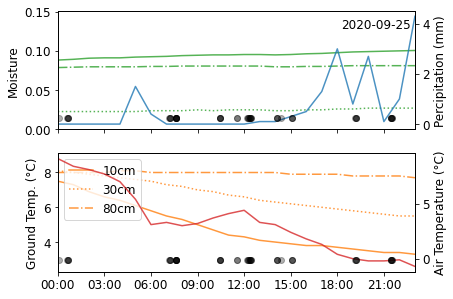

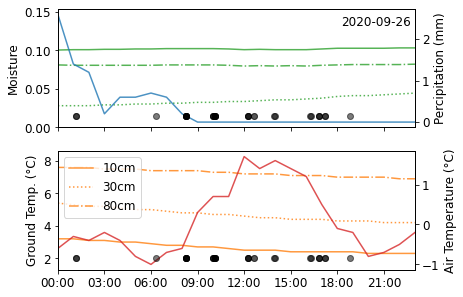

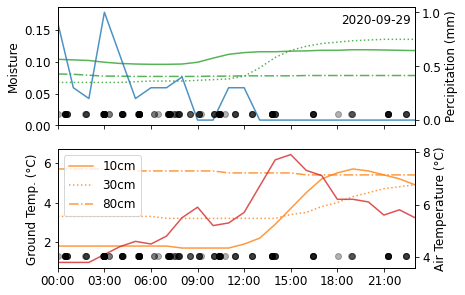

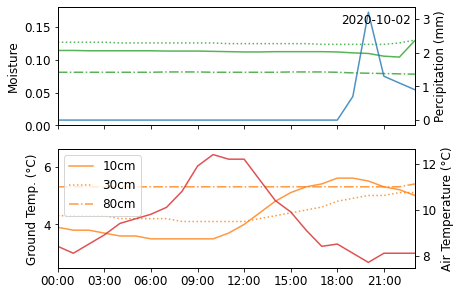

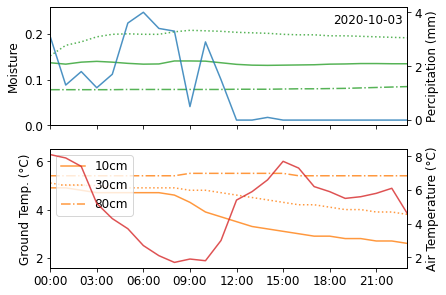

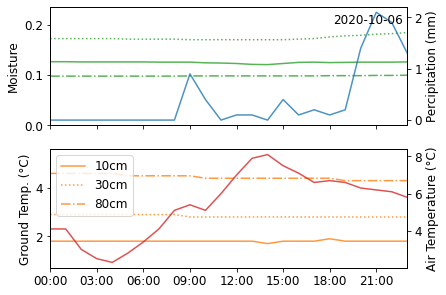

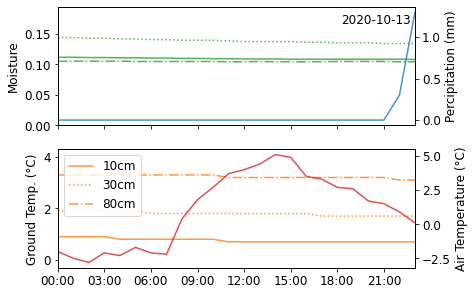

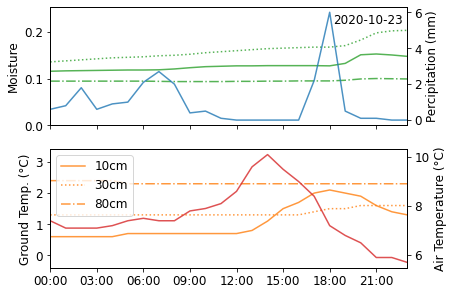

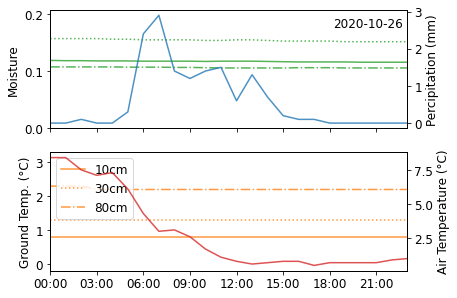

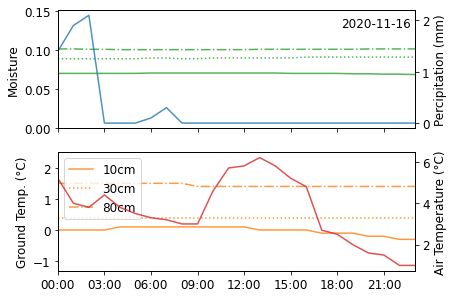

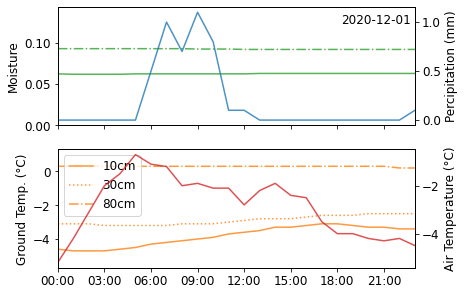

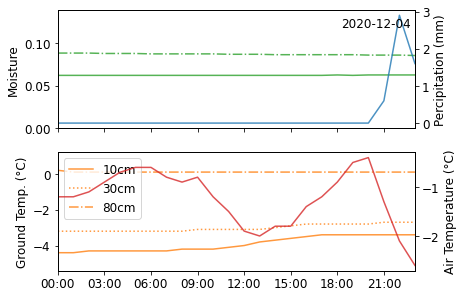

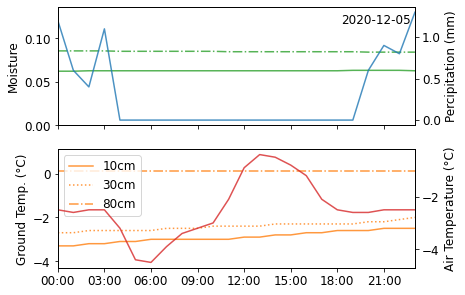

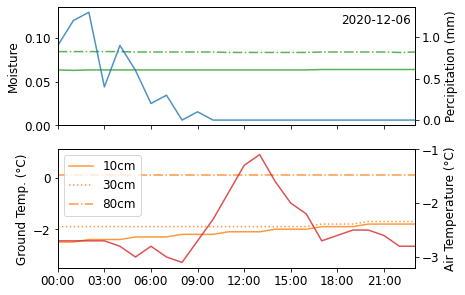

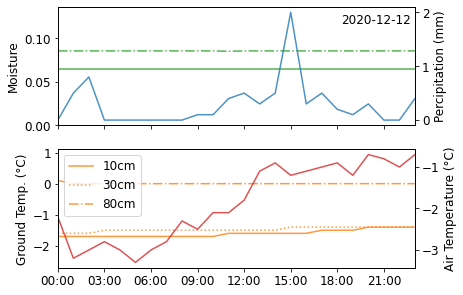

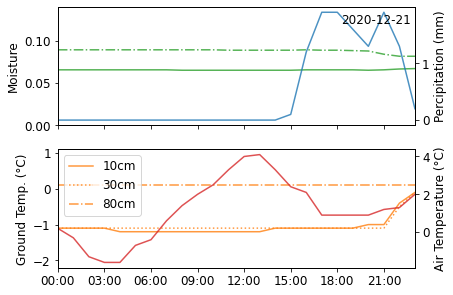

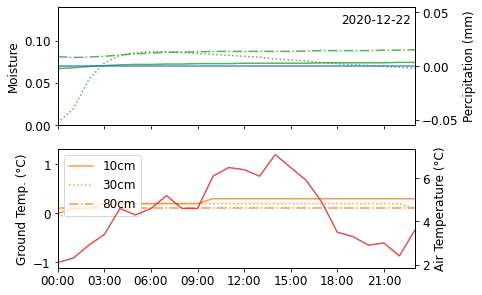

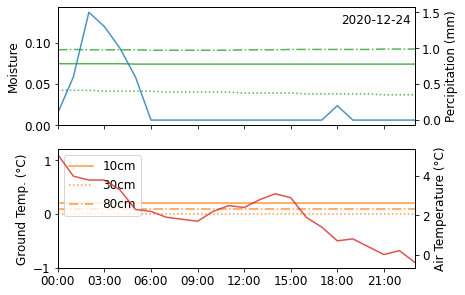

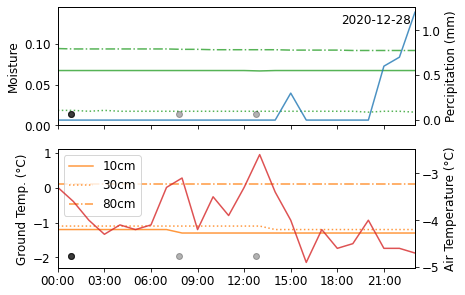

In [26]:
save_dir = f'../plot/{year}/strong_rainfall'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
for date in np.unique(df_strong['date']):
    df_cut = df_strong[df_strong.date == date]
    
    fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4, 4.8), sharex=True)
    ax2 = ax1.twinx()
    ax4 = ax1.twinx()
    ax2.plot(df_cut['267'], linestyle='-', color='C0', alpha=0.8)
    ax2.set_ylabel('Percipitation (mm)')
    ax1.plot(df_cut['SM10cm'], linestyle='-', color='C2', alpha=0.8, label='10cm')
    ax1.plot(df_cut['SM30cm'], linestyle=':', color='C2', alpha=0.8, label='30cm')
    ax1.plot(df_cut['SM80cm'], linestyle='-.', color='C2', alpha=0.8, label='80cm')
    ax1.set_ylabel('Moisture')
    y_min_a = min(min(df_cut['SM10cm']), min(df_cut['SM30cm']), min(df_cut['SM80cm']))
    y_min = math.floor(y_min_a * 1000) / 1000.0 # round down to 3thrd digit
    y_max_a = max(max(df_cut['SM10cm']), max(df_cut['SM30cm']), max(df_cut['SM80cm']))
    y_max = math.ceil(y_max_a * 1000) / 1000.0 # round up to 3thrd digit
    ax1.set_ylim(0,y_max+0.05)

    ax3 = ax0.twinx()
    ax5 = ax0.twinx()
    ax3.plot(df_cut['261'], linestyle='-', color='C3', alpha=0.8)
    ax3.set_ylabel('Air Temperature (°C)')
    ax0.plot(df_cut['T10cm'], linestyle='-', color='C1', alpha=0.8, label='10cm')
    ax0.plot(df_cut['T30cm'], linestyle=':', color='C1', alpha=0.8, label='30cm')
    ax0.plot(df_cut['T80cm'], linestyle='-.', color='C1', alpha=0.8, label='80cm')
    ax0.set_ylabel('Ground Temp. (°C)')
    y_min_a = min(min(df_cut['T10cm']), min(df_cut['T30cm']), min(df_cut['T80cm']))
    y_min = (math.floor(y_min_a * 100) / 100.0) # round down to 2nd digit
    y_max_a = max(max(df_cut['T10cm']), max(df_cut['T30cm']), max(df_cut['T80cm']))
    y_max = (math.ceil(y_max_a * 100) / 100.0) # round up to 2nd digit

    ax0.set_ylim(y_min-1,y_max+1)
    
    # Plot debris-flow events as vertical lines
    for ts_i in ts:
        ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), linestyle='--', color='k')
        ax0.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), linestyle='--', color='k')
    
    # detections
    ax4.plot(tslops_ILLx8, dslops_ILLx8,linestyle='', marker='o', color='k', alpha=0.3)
    ax5.plot(tslops_ILLx8, dslops_ILLx8,linestyle='', marker='o', color='k', alpha=0.3)
    #ax4.plot(tslops, dslops,linestyle='', marker='o', color='k', alpha=0.3)
    #ax5.plot(tslops, dslops,linestyle='', marker='o', color='k', alpha=0.3)
    ax4.set_ylim(0,10)
    ax5.set_ylim(0,10)
    ax4.get_yaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    
    ax0.set_xlim(df_cut.index[0], df_cut.index[-1])
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    ax0.legend(loc='upper left')
    fig.text(0.74,0.83, f'{date}')
    plt.savefig(save_dir + f'/{date}_ILLx8.png',bbox_inches='tight', dpi=300)